In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats  
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.metrics import brier_score_loss, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

seed = 1984

# Overview

The assignment for the challenge was to fill the missing data in the test set using the train set. To do this, I train a model using the train set, to estimate the *value* feature, which I understand would be the target here. 

# Load data

In [110]:
train_set = pd.read_csv('training.csv') 
test_set  = pd.read_csv('testing.csv')

# Data exploration

In [111]:
def missing_zero_values_table(df):
    """
    Parameters:
        df: dataframe to use
    
    Returns:
        mz_table: table with a count of blank values and missing values 
                    and these values as percentage of the total
    """
    no_val = (df == ' ').astype(int).sum(axis=0)
    zero_val = ((df == 0.00).astype(int).sum(axis=0) / len(df)) * 100 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([no_val, mis_val, zero_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = {0 : 'Blank Values', 1 : 'Missing Values',
                                          2 : '% Zero Values', 3 : '% of Total Values'})
    mz_table = mz_table.sort_values('% of Total Values', ascending=False).round(1)

    return mz_table

In [112]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city       2000 non-null   object
 1   website    2000 non-null   object
 2   employees  2000 non-null   object
 3   status     2000 non-null   object
 4   value      2000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [113]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city       2000 non-null   object
 1   website    2000 non-null   object
 2   employees  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


- **Missing values table**

In [114]:
missing_zero_values_table(train_set)

,Blank Values,Missing Values,% Zero Values,% of Total Values
city,0,0,0.0,0.0
website,0,0,0.0,0.0
employees,0,0,0.0,0.0
status,0,0,0.0,0.0
value,0,0,90.0,0.0


In [115]:
missing_zero_values_table(test_set)

,Blank Values,Missing Values,% Zero Values,% of Total Values
city,0,0,0.0,0.0
website,0,0,0.0,0.0
employees,0,0,0.0,0.0


# EDA

In [117]:
def make_barplot(df, var_group, var_agg, aggregation, rot = False):
    '''
    Parameters: 
        df : df to use
        var_gr : feature used to group 
        var_agg: feature used to create the aggregation needed
        aggregation : aggregation to use to aggregate var_agg
        rot : False if X axis should not be rotated 
    
    Returns : 
        barchart mean of var_group by var_mn
    '''
    # Grouping to plot
    df_gr = df.groupby([var_group], as_index=False)[var_agg].agg(aggregation)

    # Gráfico
    sns.set_style("white")
    plt.figure(figsize=(12,8))
    sns.set_context("paper", font_scale=1.5)
    
    plot = sns.barplot(x=var_group, y=var_agg, data=df_gr, palette="Set3")
    if rot : 
        for item in plot.get_xticklabels():
            item.set_rotation(90)
    plt.show()

In [116]:
train_set['employees'] = np.select([train_set['employees'] == '1-10',
                                    train_set['employees'] == '11-50',
                                    train_set['employees'] == '51-100',
                                    train_set['employees'] == '101-250',
                                    train_set['employees'] == '251-500',
                                    train_set['employees'] == '501-1000',
                                    train_set['employees'] == '1001-5000',
                                    train_set['employees'] == '5001-10000',
                                    train_set['employees'] == '10001+',
                                   ], 
                                   ['a. 1-10', 'b. 11-50',  'c. 51-100',
                                    'd. 101-250', 'e. 251-500', 'f. 501-1000',
                                    'g. 1001-5000','h. 5001-10000', 'i. 10001+'])


## Univariate

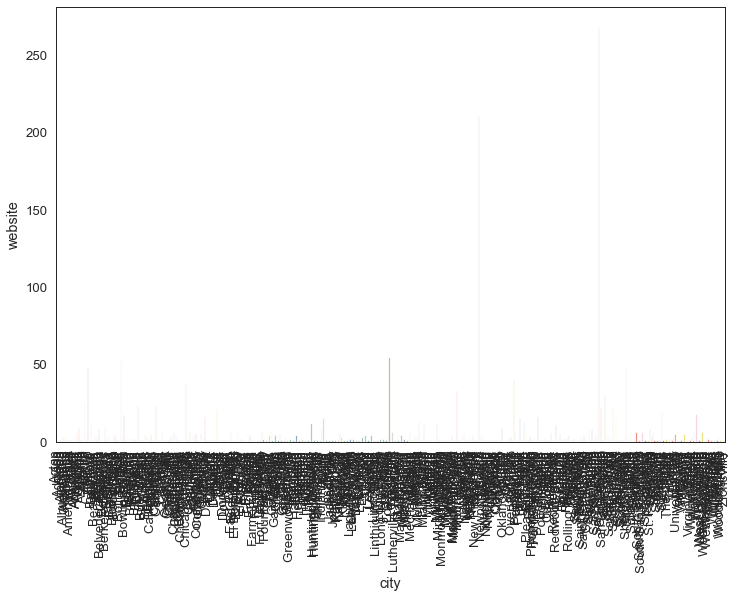

In [118]:
make_barplot(train_set, 'city', 'website', 'count', rot=True)

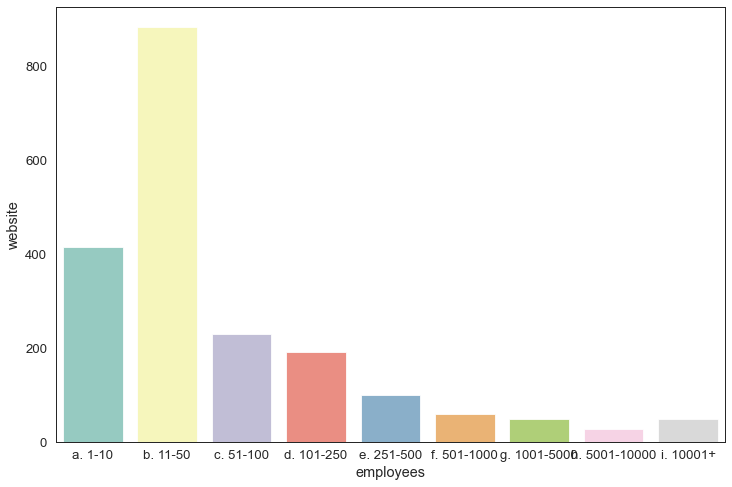

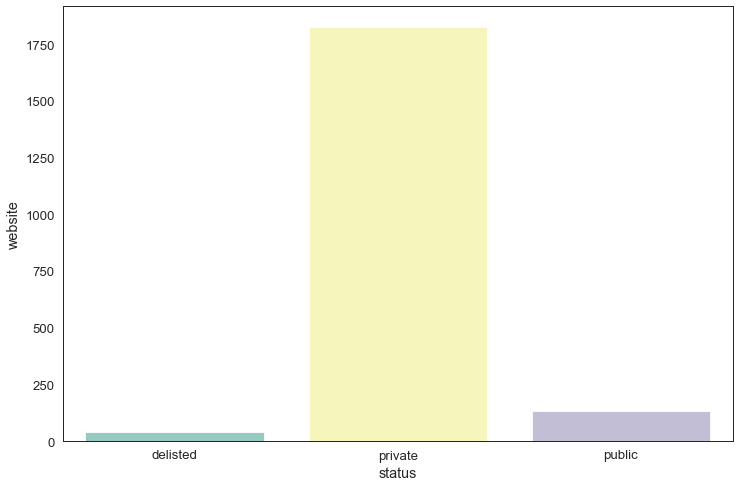

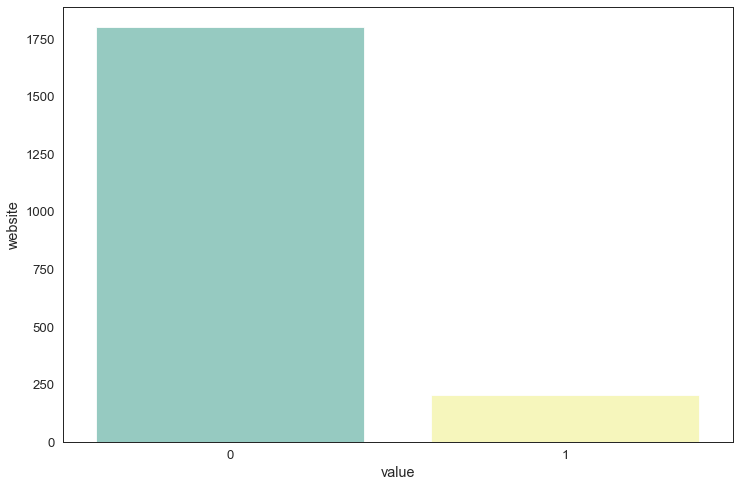

In [119]:
cols = ['employees', 'status', 'value']
for col in cols: 
    make_barplot(train_set, col, 'website', 'count')

## Bivariate

In [120]:
def pct_bar_labels(ax1):
    plt.ylabel('Relative Frequency (%)')
    plt.xticks(rotation = 0)
    plt.yticks([])   
    # Set individual bar lebels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = 10, color = 'black')

def composition(cat, cat_target): 
    """
    Parameters: 
        cat: categorical feature to plot
        cat_target: target feature
        
    Returns: 
        plot with % of observations by category, according to target value
    """
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, 
                                                      columns = cat_target, 
                                                      normalize = 'index')*100, 2)
    #pct_cat_grouped_by_cat_target.sort_values(by=1.0, inplace=True)
    
    # Plot relative freq of target by a categorical variable
    sns.set(rc={'figure.figsize':(15,6)})
    
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(color = ['#E74C3C', '#76D7C4'])
    plt.title('Percentage target by %s' %cat.name)
    pct_bar_labels(ax1)
    plt.show()
    
def chi_square(cat, cat_target):
    cat_grouped_by_cat_target = pd.crosstab(index = cat, columns = cat_target)
    p_value = stats.chi2_contingency (cat_grouped_by_cat_target)[1]
    exp_vale = stats.chi2_contingency (cat_grouped_by_cat_target)[3]
    
    return p_value, exp_vale

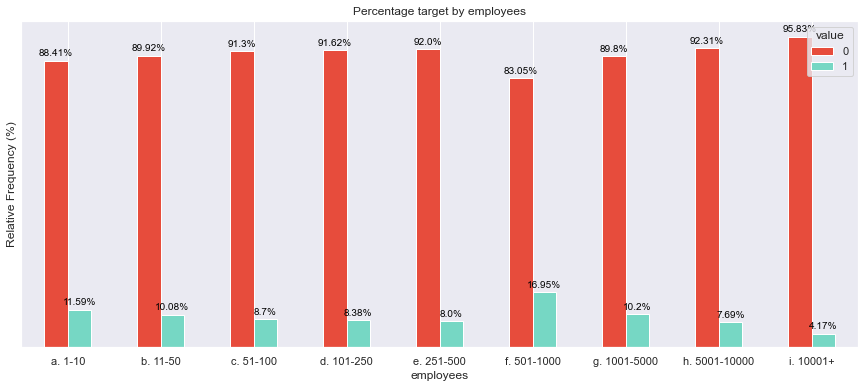

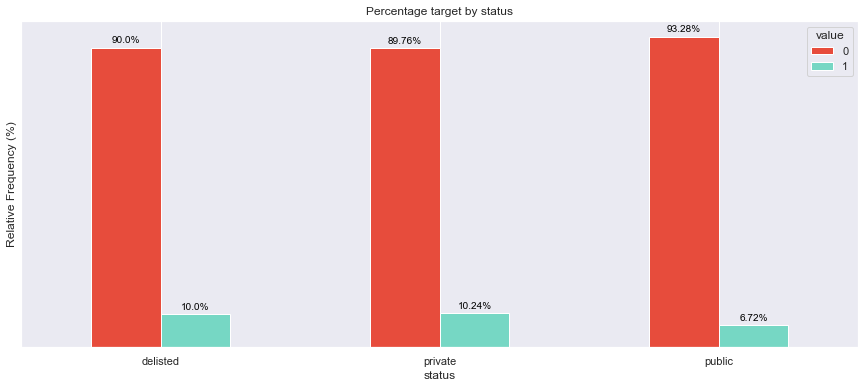

In [121]:
var_list = ['employees', 'status']
for var in var_list:
    composition(train_set[var], train_set['value'])

The number of employees seems to have a clear relationship with the value column. 

**Chi-square Test:** This is a test of independence. It tests if there is a significant relationship between two categorical variables.The data is usually displayed in a cross-tabulation format with each row representing a category for one variable and each column representing a category for another variable. Chi-square test of independence tests the data as a whole. This means that one will not be able to tell which levels (categories) of the variables are responsible for the relationship if the Chi-square table is larger than 2×2

    - H0 (Null Hypothesis): There is no relationship between variable one and variable two.

    - H1 (Alternative Hypothesis): There is a relationship between variable 1 and variable 2.

If the p-value is significant (less than 0.05), you can safely reject H0. We need also to check that the expected cell frequencies are greater than or equal to 5. 

In [59]:
var_list = ['employees', 'status']
for var in var_list:
    print(var, chi_square(train_set[var], train_set['value']))

employees (0.4582465898384428, array([[372.6,  41.4],
       [794.7,  88.3],
       [207. ,  23. ],
       [171.9,  19.1],
       [ 90. ,  10. ],
       [ 53.1,   5.9],
       [ 44.1,   4.9],
       [ 23.4,   2.6],
       [ 43.2,   4.8]]))
status (0.42250429124733124, array([[  36. ,    4. ],
       [1643.4,  182.6],
       [ 120.6,   13.4]]))


It seems the p value is higher than 0.05, thus we could not reject H0, but regardless, as the frequencies were higher than 5, we can't trust the test. 

# Model

## Train test split

In [84]:
# select features to use and convert to dummies
cols = ['city', 'employees', 'value']

df_dummies = pd.get_dummies(train_set.loc[:,cols])

# Train - test original
X_train, X_test = train_test_split(df_dummies, test_size=0.2, 
                                   random_state = seed, 
                                   stratify = df_dummies['value'])
y_train = X_train['value']
y_test = X_test['value']

x_train = X_train.drop(['value'], axis=1)
x_test = X_test.drop(['value'], axis=1)

## Train model

I fit a small classiffier to see how a model does with this data.<br>
As there are few features, there would probably not be much difference between a RF and an XGBoost model.

In [104]:
def class_report(y_pred_train, y_train, y_pred_test, y_test):
    """ 
    y_pred_train: predicted y values for train dataset
    y_train: ground truth for train dataset
    y_pred_test: predicted y values for test dataset
    y_test: ground truth for test dataset

    Returns: classification reports for train and test
    """
    print('TRAIN Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_train, y_pred_train))
    print('TEST Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_test, y_pred_test))

def feature_importance(model, X_train, top_features):
    """ 
    model: model from which you want to get the feature importance
    X_train : train set used to train the model
    top_features: number of features you want to see in the graph

    Returns: feature importance graph
    """
    plt.figure(figsize = (8,8))
    feat_importances = pd.DataFrame({'columns': X_train.columns, 
                            'importance': model.feature_importances_}).sort_values('importance',
                                                                                       ascending=False)
    sns.set_context("paper", rc={"font.size":10, "xtick.labelsize":12,"ytick.labelsize":12, "axes.labelsize":10}) 
    sns.barplot(x="importance", y="columns", data = feat_importances.iloc[:top_features,:])
    plt.show()
    
def split_x_y(df, cols): 
    
    x = df.loc[:,cols]
    x = pd.get_dummies(x)
    y = df['value']
    
    return x, y

## Dummy classifier

In [122]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

y_pred_train_dumm = dummy_clf.predict(x_train)
y_pred_test_dumm = dummy_clf.predict(x_test)

class_report(y_pred_train_dumm, y_train, 
              y_pred_test_dumm, y_test)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1440
           1       0.00      0.00      0.00       160

    accuracy                           0.90      1600
   macro avg       0.45      0.50      0.47      1600
weighted avg       0.81      0.90      0.85      1600

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       360
           1       0.00      0.00      0.00        40

    accuracy                           0.90       400
   macro avg       0.45      0.50      0.47       400
weighted avg       0.81      0.90      0.85       400



## RF

In [107]:
# Train with original dataset
rfc = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=10)
rf_mdl = rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

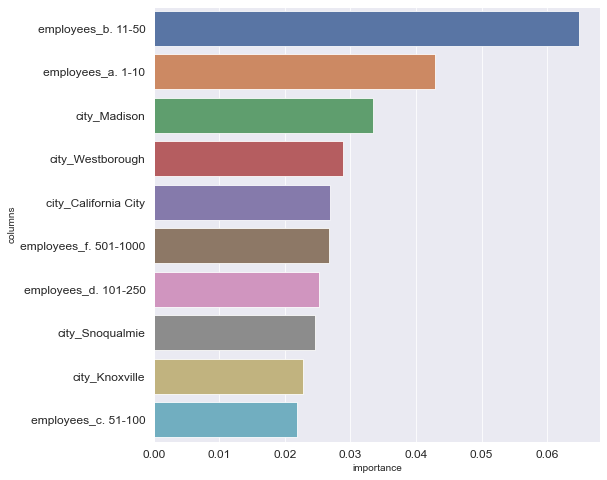

In [86]:
feature_importance(rf_mdl, x_train, 10)

In [123]:
print('Scores')
scoring=['accuracy','precision_macro','recall_macro']
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #Define evaluation procedure 

scores_ori = cross_validate(rfc, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))
print('')

Scores
Mean Accuracy: 0.9000
Mean Precision: 0.4500
Mean Recall: 0.5000



In [125]:
class_report(y_pred_train, y_train, 
              y_pred_test, y_test)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1440
           1       0.00      0.00      0.00       160

    accuracy                           0.90      1600
   macro avg       0.45      0.50      0.47      1600
weighted avg       0.81      0.90      0.85      1600

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       360
           1       0.00      0.00      0.00        40

    accuracy                           0.90       400
   macro avg       0.45      0.50      0.47       400
weighted avg       0.81      0.90      0.85       400



## Results & next steps

As a preliminary conclusion I would say: <br>
As the model is currently, there is no difference between training a model & predicting the most frequent category, meaning 0. <br>

Some things that could be tried to improve the model: <br>
    - reduce dimensionality in cities, as it can't be used as is. There are too many cities as to use them as a feature. It would be useful if it could be at a higher level, maybe jurisdiction or even state. <br>
    - for the website, it would be useful if there was any information that could be obtained about the type of site, or activity the company does.  
    - in terms of the model, some over/under sampling could be included as to try to get a better prediction for the target. 